# What if there was no covid-19…?
## Predict the traffic in airports if Covid-19 did not happen.

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import pickle
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
df = pickle.load(open('pickles/df_clean_grouped_until_2020.pkl', 'rb'))

In [3]:
df = df[['arr_flights', 'arr_del15']]
df.head(2)

,arr_flights,arr_del15
year_month,,
2003-06-01,333348.0,55349.0
2003-07-01,347438.0,63943.0


#### Train, Validation, and Test set

Train: from 2003-06-01 to 2019-06-01

Validation Set: from 2019-06-01 to 2019-12-01

Test Set: 2020-01-01 to 2020-12-01

We can also say that the data from 2020 is comparison set

In [4]:
df_train = df.loc['2003-06':'2019-06']
df_val = df.loc['2019-06':'2019-12']
df_2020 = df.loc['2020']

In [5]:
print('shape of train set: ', df_train.shape)
print('shape of validation set: ', df_val.shape)
print('shape of test set: ', df_2020.shape)

shape of train set:  (193, 2)
shape of validation set:  (7, 2)
shape of test set:  (12, 2)


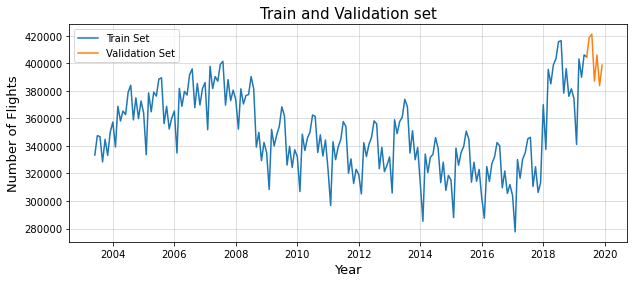

In [6]:
# plot train and validation set
plt.figure(figsize=(10, 4))

plt.plot(df_train['arr_flights'], label = 'Train Set')
plt.plot(df_val['arr_flights'], label = 'Validation Set')

plt.xlabel('Year', fontsize = 13)
plt.ylabel('Number of Flights', fontsize = 13)
plt.title('Train and Validation set', fontsize = 15)
plt.legend()
plt.grid(alpha = 0.5)
plt.savefig("visualizations/45_train_validation.png", dpi=100)

### Decompose the timeseries data into components

<Figure size 1000x800 with 0 Axes>

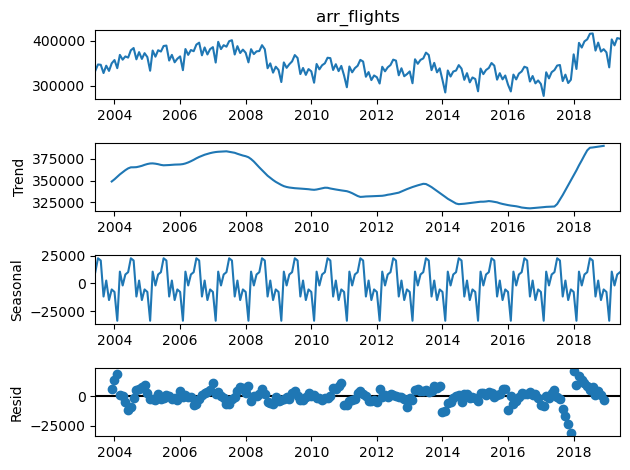

In [7]:
plt.style.use('default')
plt.figure(figsize = (10, 8))
sm.tsa.seasonal_decompose(df_train['arr_flights']).plot()
#plt.show()
plt.savefig("visualizations/46_decomposed.png", dpi=100)

### Check for Stationarity

In [8]:
def adfuller_test(test_column, p_val = 0.05):
    '''
    Method to test for ADF test
    
    test_column: The column to be checked for stationarity
    p_val: default value is 0.05
    '''
    result = adfuller(test_column)
    labels= ['Test Statistic','p-value','Num Lags','Num Observations']
    
    for val, label in zip(result, labels):
        print(label+' : '+ str(val))
    if result[1] <= p_val:
        print(f'Series is stationary. Null hypothesis rejected with {(1-result[1])*100}% confidence.')
    else:
        print(f'Series is non-Stationary. Null hypothesis accepted with {result[1]*100}% confidence.')
        
    

In [9]:
adfuller_test(df_train['arr_flights'])

Test Statistic : -2.2240912573005347
p-value : 0.1976181862776027
Num Lags : 12
Num Observations : 180
Series is non-Stationary. Null hypothesis accepted with 19.76181862776027% confidence.


## Differencing

As the data is non stationary, we will have to make it stationary.

We know that the data has seasonality of 1-year. So we can make this data stationart by subtracting current data with the data of last year. So the difference will remove the seasonal effect of the data.

In [10]:
df_train['arr_flights_diff_1'] = df['arr_flights'] - df_train['arr_flights'].shift(12)

In [11]:
df_train.head(14)

,arr_flights,arr_del15,arr_flights_diff_1
year_month,,,
2003-06-01,333348.0,55349.0,NaN
2003-07-01,347438.0,63943.0,NaN
2003-08-01,346804.0,66535.0,NaN
2003-09-01,328397.0,42596.0,NaN
2003-10-01,344763.0,43636.0,NaN
2003-11-01,333149.0,63139.0,NaN
2003-12-01,349972.0,77902.0,NaN
2004-01-01,357300.0,80874.0,NaN
2004-02-01,339244.0,72044.0,NaN


In [12]:
## Testing for stationarity again

adfuller_test(df_train['arr_flights_diff_1'].dropna())

Test Statistic : -2.3380407933677008
p-value : 0.15999233173983318
Num Lags : 14
Num Observations : 166
Series is non-Stationary. Null hypothesis accepted with 15.999233173983319% confidence.


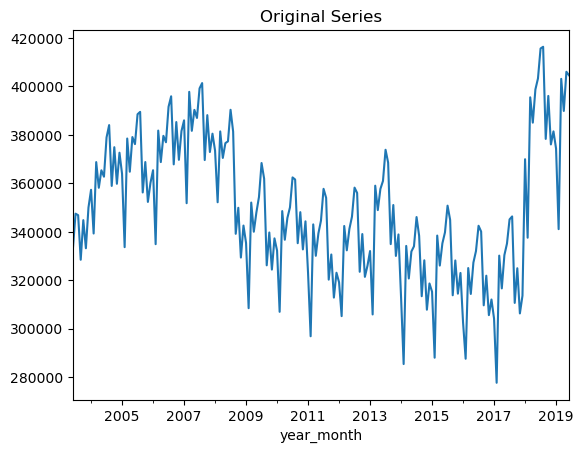

In [13]:
df_train['arr_flights'].plot().set_title('Original Series')
plt.savefig("visualizations/47_original_series.png", dpi=100)

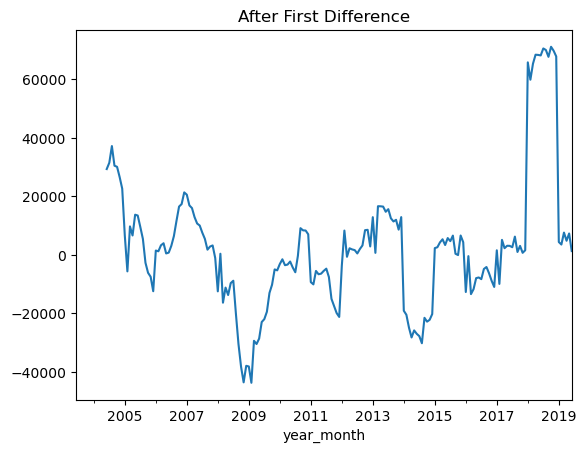

In [14]:
df_train['arr_flights_diff_1'].plot().set_title('After First Difference')
plt.savefig("visualizations/48_first_difference.png", dpi=100)

In [15]:
# Apply difference again

df_train['arr_flights_diff_2'] = df_train['arr_flights_diff_1'] - df_train['arr_flights_diff_1'].shift(12)

In [16]:
## Testing for stationarity again

adfuller_test(df_train['arr_flights_diff_2'].dropna())

Test Statistic : -3.284320658042666
p-value : 0.015594055496142034
Num Lags : 12
Num Observations : 156
Series is stationary. Null hypothesis rejected with 98.4405944503858% confidence.


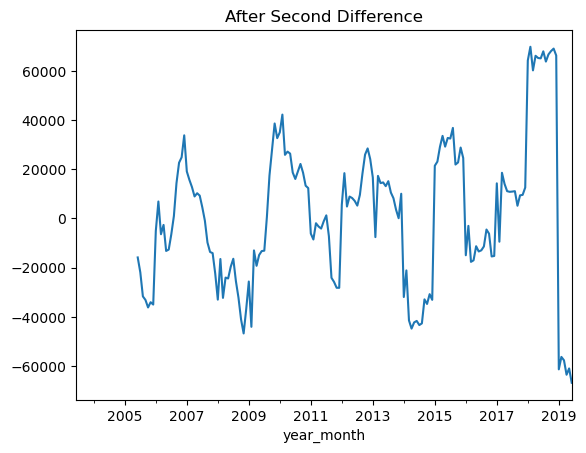

In [17]:
df_train['arr_flights_diff_2'].plot().set_title('After Second Difference')
plt.savefig("visualizations/49_second_difference.png", dpi=100)

## Data is stationary now

Find values of p, d, and q for ARiMA

> 1. For AR --> p = ? (Check from PACF)
2. For I --> d = 2 (achieved stationarity after 2 differences)
3. For MA --> q = 2 (Check from ACF)

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

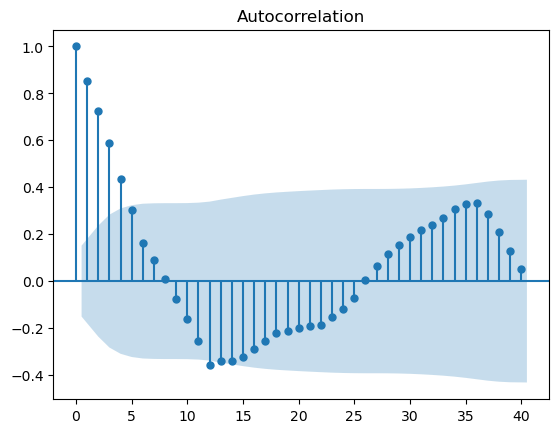

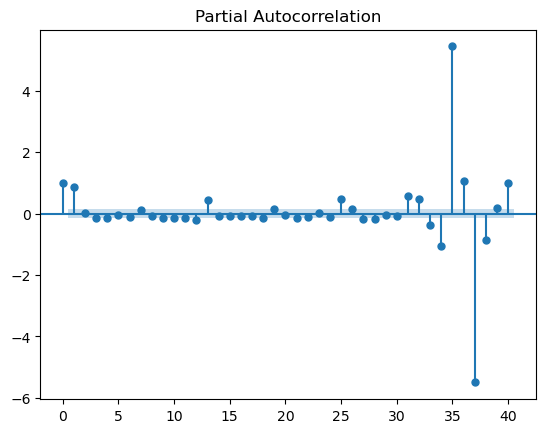

In [19]:
#plt.figure(figsize = (12, 3))
plot_acf(df_train['arr_flights_diff_2'].iloc[25:], lags = 40)
plt.savefig("visualizations/50_autocorr.png", dpi=100)
plot_pacf(df_train['arr_flights_diff_2'].iloc[25:], lags = 40)
plt.savefig("visualizations/50_partial_ACF.png", dpi=100)

#### From the above graphs p = 2, q = 5.

In [20]:
from statsmodels.tsa.arima_model import ARIMA

In [21]:
model_arima = ARIMA(df_train['arr_flights'], order = (2, 2, 5)).fit()
#model_arima.summary()

In [22]:
df_train.shape

(193, 4)

In [23]:
predicted_arima = model_arima.predict(start = 192, end = 198)
predicted_arima

2019-06-01   -21715.790612
2019-07-01    -4775.247161
2019-08-01    24690.121346
2019-09-01   -40670.377632
2019-10-01    48107.117859
2019-11-01   -41424.080886
2019-12-01    23654.813049
Freq: MS, dtype: float64

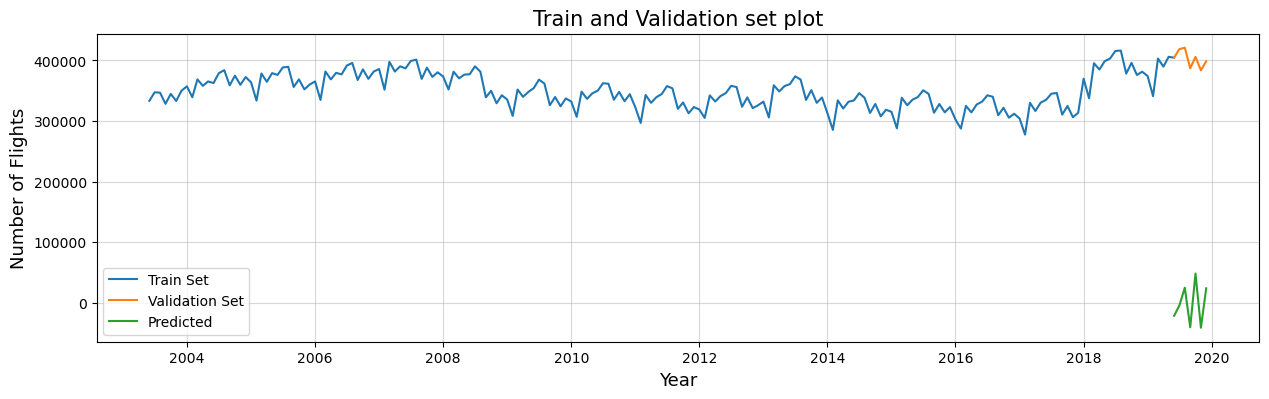

In [24]:
# plot train and validation set
plt.figure(figsize=(15, 4))

plt.plot(df_train['arr_flights'], label = 'Train Set')
plt.plot(df_val['arr_flights'], label = 'Validation Set')
plt.plot(predicted_arima, label = 'Predicted')

plt.xlabel('Year', fontsize = 13)
plt.ylabel('Number of Flights', fontsize = 13)
plt.title('Train and Validation set plot', fontsize = 15)
plt.legend()
plt.grid(alpha = 0.5)
plt.savefig("visualizations/51_ARIMA.png", dpi=100)

In [25]:
mean_absolute_percentage_error(df_val['arr_flights'], predicted_arima)

1.0059404942894457

#### The results of ARIMA is very poor. This is because ARIMA doesnot work well on seasonal data

#### SARIMAX

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [27]:
model_sarimax = SARIMAX(df_train['arr_flights'], order = (1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()

In [28]:
predicted_sarimax = model_sarimax.predict(start = 192, end = 198)
predicted_sarimax

2019-06-01    411653.909580
2019-07-01    416979.891940
2019-08-01    417033.712407
2019-09-01    380618.583572
2019-10-01    397495.467119
2019-11-01    378214.405037
2019-12-01    384229.762261
Freq: MS, Name: predicted_mean, dtype: float64

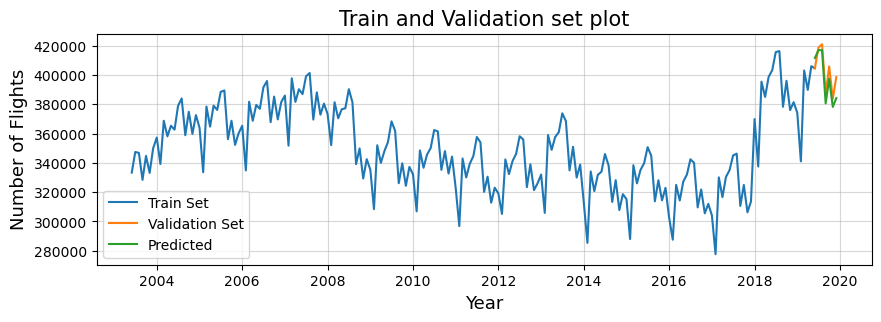

In [29]:
# plot train and validation set
plt.figure(figsize=(10, 3))

plt.plot(df_train['arr_flights'], label = 'Train Set')
plt.plot(df_val['arr_flights'], label = 'Validation Set')
plt.plot(predicted_sarimax, label = 'Predicted')

plt.xlabel('Year', fontsize = 13)
plt.ylabel('Number of Flights', fontsize = 13)
plt.title('Train and Validation set plot', fontsize = 15)
plt.legend()
plt.grid(alpha = 0.5)
plt.savefig("visualizations/52_train_test_plot_SARIMA.png", dpi=100)

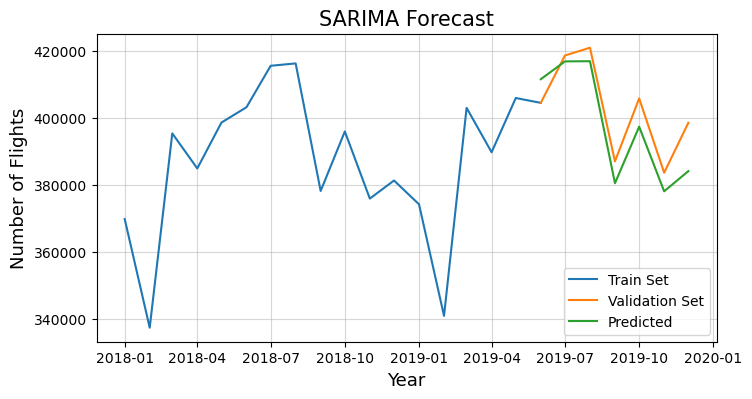

In [30]:
# plot train and validation set
plt.figure(figsize=(8, 4))

plt.plot(df_train.loc['2018':]['arr_flights'], label = 'Train Set')
plt.plot(df_val['arr_flights'], label = 'Validation Set')
plt.plot(predicted_sarimax, label = 'Predicted')

plt.xlabel('Year', fontsize = 13)
plt.ylabel('Number of Flights', fontsize = 13)
plt.title('SARIMA Forecast', fontsize = 15)
plt.legend()
plt.grid(alpha = 0.5)
plt.savefig("visualizations/53_SARIMA_Forecast.png", dpi=100)

In [31]:
## SARIMAX fits the data very well.

In [32]:
#model_sarimax.summary()

## Evaluation MAPE

In [33]:
mean_absolute_percentage_error(df_val['arr_flights'], predicted_sarimax)

0.017064877970175193

## Extending forecast to 2020

In [34]:
predicted_sarimax = model_sarimax.predict(start = 192, end = 210)
predicted_sarimax

2019-06-01    411653.909580
2019-07-01    416979.891940
2019-08-01    417033.712407
2019-09-01    380618.583572
2019-10-01    397495.467119
2019-11-01    378214.405037
2019-12-01    384229.762261
2020-01-01    378783.545940
2020-02-01    347332.488236
2020-03-01    405918.214960
2020-04-01    393068.228278
2020-05-01    408181.117940
2020-06-01    408893.716730
2020-07-01    421077.621489
2020-08-01    420704.285537
2020-09-01    385367.301024
2020-10-01    401667.562134
2020-11-01    382877.639661
2020-12-01    389300.359579
Freq: MS, Name: predicted_mean, dtype: float64

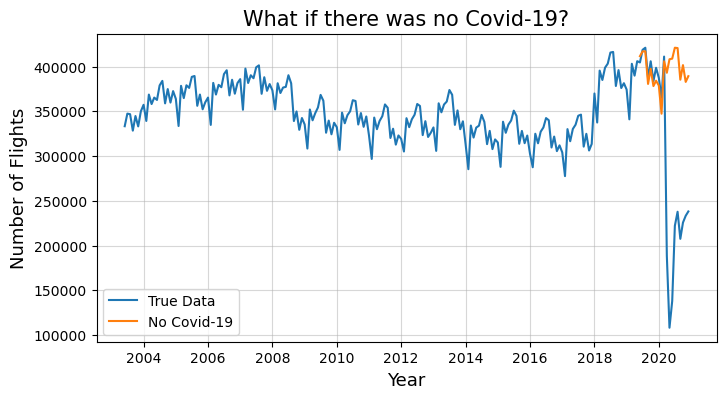

In [35]:
# plot train and validation set
plt.figure(figsize=(8, 4))

plt.plot(df['arr_flights'], label = 'True Data')
plt.plot(predicted_sarimax, label = 'No Covid-19')

plt.xlabel('Year', fontsize = 13)
plt.ylabel('Number of Flights', fontsize = 13)
plt.title('What if there was no Covid-19?', fontsize = 15)
plt.legend()
plt.grid(alpha = 0.5)
plt.savefig("visualizations/54_no_covid_1.png", dpi=100)

## If there was no covid-19, then the traffic would have followed the above trend

### Taking a closer look on 2020

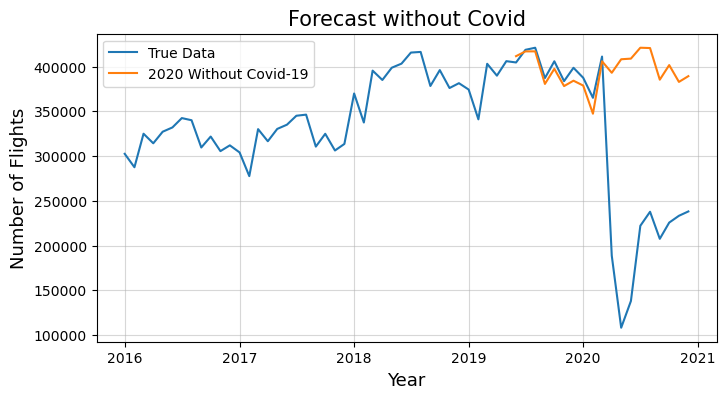

In [36]:
# plot train and validation set
plt.figure(figsize=(8, 4))

plt.plot(df['2016':]['arr_flights'], label = 'True Data')
plt.plot(predicted_sarimax, label = '2020 Without Covid-19')

plt.xlabel('Year', fontsize = 13)
plt.ylabel('Number of Flights', fontsize = 13)
plt.title('Forecast without Covid', fontsize = 15)
plt.legend()
plt.grid(alpha = 0.5)
plt.savefig("visualizations/55_no_covid_2.png", dpi=100)